# Neural Collaborative Filtering Model

In this notebook I will solve the second problem from my idea: Predict ratings for those films that "similar" users rated above 3 and already from these predictions give recommendations for viewing.
Neural Collaborative Filtering is well suited for such purposes, with its help we will give recommendations to the user based on the films that he and other users have watched.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Dropout, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import json
from keras.models import load_model

In [2]:
u_cols = ['userId', 'movieId', 'rating','timestamp']
rating_df = pd.read_csv("../data/raw/rating.csv", index_col=0)

In [3]:
user_Ids = rating_df["userId"].unique()
num_users = len(user_Ids)+1
movie_Ids = rating_df["movieId"].unique()
num_movies = len(movie_Ids)+1

To begin with, let's divide our dataset into test, train, validate sets

In [4]:
train_temp, test = train_test_split(rating_df, test_size=0.2, random_state=42)
train, validation = train_test_split(train_temp, test_size=0.2, random_state=42)

## Model Architecture 

Neural Collaborative Filtering replaces the user-item inner product with a neural architecture.

![NFC_model_arch](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*aP-Mx266ExwoWZPSdHtYpA.png)

Here's a brief overview of the architecture:

Input Layer:
* Two separate input layers for user and movie, each of size 1, representing user and movie indices.

Embedding Layers:
* Embedding layers for both user and movie, which transform the input indices into dense vectors of a specified size (embedding size).
* The embeddings capture latent factors for users and movies.

MLP Component:
* The embedded user and movie vectors are fed into separate Multi-Layer Perceptrons (MLPs).
* The output of each MLP is flattened to create vectors of fixed size.
* These vectors are concatenated to form a single vector.

Matrix Factorization Component:
* Another set of embedding layers for user and movie indices are used to create latent factor vectors.
* The dot product of the user and movie latent factor vectors is taken.

Concatenation and Fusion:
* The output vectors from the MLP and the dot product from the matrix factorization are concatenated.
* This combination aims to capture both the non-linear interactions and the latent factors.

Fully Connected Layers:
* The concatenated vector is passed through fully connected layers with batch normalization and dropout for regularization.
* This helps the model learn complex representations and prevent overfitting.

Output Layer:
* The final output layer with a single neuron and linear activation function is used to predict the rating or preference value.

Loss and Optimization:
* The model is trained using the mean squared error loss, commonly used for regression tasks.
* Adam optimizer with a specified learning rate is employed to minimize the loss during training.


In [5]:
def model_cf(embed_size=10, drop_out_prob=0.2):
    movie_input = Input(shape=[1], name="movie-input")
    user_input = Input(shape=[1], name="user-input")

    movie_emb_mlp = Embedding(num_movies, embed_size, name="movie-embedding-mlp")(movie_input)
    movie_vec_mlp = Flatten(name="flatten-movie-mlp")(movie_emb_mlp)

    user_emb_mlp = Embedding(num_users, embed_size, name="user-embedding-mlp")(user_input)
    user_vec_mlp = Flatten(name="flatten-user-mlp")(user_emb_mlp)

    movie_embedding_mf = Embedding(num_movies, embed_size, name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    predicted_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    predicted_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)
    combine_mlp_mf = concatenate([predicted_mf, predicted_mlp], axis=-1, name='pred_mf')


    result = Dense(1, name='result', activation='linear')(combine_mlp_mf) 
    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')    

    return model

##  Model Training

Now that the model has been created, it can be trained on a training set, with an embedded layer size of 5 and with the default probability specified in the function for creating the model. There will be 10 epochs in the learning process, to save the model with the least loss on validation data, we will use ModelCheckpoint.

In [6]:
model_checkpoint = ModelCheckpoint('../models/rec_films.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

model = model_cf(embed_size=5)
history = model.fit(
    [train.userId, train.movieId], train.rating, 
    validation_data=([validation.userId, validation.movieId], validation.rating),  # Update here
    epochs=10, 
    batch_size=64,
    callbacks=[model_checkpoint]
)


Epoch 1/10


 999/1000 [============================>.] - ETA: 0s - loss: 2.0491
Epoch 1: val_loss improved from inf to 1.12546, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 9s 5ms/step - loss: 2.0484 - val_loss: 1.1255
Epoch 2/10
  26/1000 [..............................] - ETA: 3s - loss: 1.3644

D:\innopolis\PMLDL\movies\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 992/1000 [============================>.] - ETA: 0s - loss: 1.2145
Epoch 2: val_loss improved from 1.12546 to 0.96695, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 4s 4ms/step - loss: 1.2130 - val_loss: 0.9670
Epoch 3/10
 987/1000 [============================>.] - ETA: 0s - loss: 0.9910
Epoch 3: val_loss improved from 0.96695 to 0.89499, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9900 - val_loss: 0.8950
Epoch 4/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.8664
Epoch 4: val_loss improved from 0.89499 to 0.89075, saving model to ../models\rec_films.h5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8664 - val_loss: 0.8908
Epoch 5/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.7991
Epoch 5: val_loss did not improve from 0.89075
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7994 - val_loss: 0.8986
Epoch 6/10


## Evaluating 

Evaluating will be carried out on a test dataset previously unknown to our model with best weights.

1. Root Mean Squared Error (RMSE): RMSE quantifies the average magnitude of the errors between predicted and actual values.

2. Mean Absolute Error (MAE): MAE calculates the average absolute differences between predicted and actual values, providing a measure of the model's precision without considering the direction of errors.

3. R-squared (R2) Score: R2 Score assesses the proportion of the variance in the target variable explained by the model.

In [7]:
model = load_model('../models/rec_films.h5')

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
test_predictions = model.predict([test.userId, test.movieId])

625/625 [==============================] - 1s 2ms/step


Validation RMSE: 0.9465736155137746
Validation MAE: 0.7492777075648308
Validation R^2 Score: 0.2905834196940684


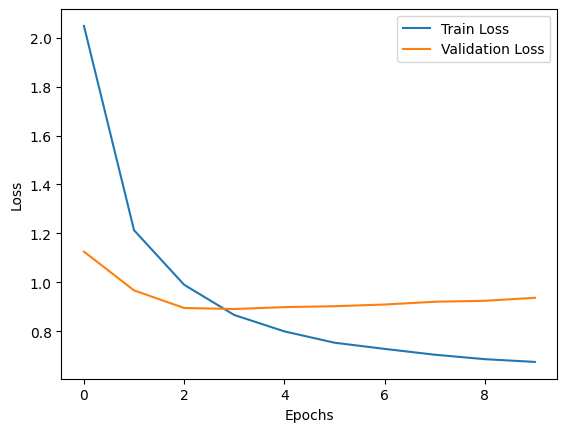

In [9]:
test_rmse = np.sqrt(mean_squared_error(test.rating, test_predictions))
test_mae = mean_absolute_error(test.rating, test_predictions)
test_r2 = r2_score(test.rating, test_predictions)

print(f'Validation RMSE: {test_rmse}')
print(f'Validation MAE: {test_mae}')
print(f'Validation R^2 Score: {test_r2}')

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Metrics indicate that the model has certain limitations in the accuracy of predicting user ratings for movies. RMSE and MAE, although slightly above zero, may be acceptable. However, the low value of R^2 Score (0.29) indicates that the model does not explain a significant part of the variance in the data, which may indicate the limited ability of the model to predict user preferences. Overall, the results suggest that the model can be improved to make more accurate predictions of user ratings.

## Recommendation of the top N movies for the user

After all the actions, you can try to make top N recommendations for the user, depending on his previous ratings. To do this, it will be convenient to create a function that outputs the names of the top N movies. Also, in the function itself, we will offer to make predictions on the rating of exactly those films that "similar" users have watched, we will upload the ids of "similar" users from a json file

In [10]:
movie_df = pd.read_csv("../data/raw/movies.csv")

In [11]:
def recommendation_top(rec_model, client_id, top_k):
    movie_watched = rating_df[rating_df['userId'] == client_id]['movieId'].values
    
    json_file_path = f'../data/users/similar_users_to_{client_id}.json'

    with open(json_file_path, 'r') as file:
        similar_users_data = json.load(file)
    
    # Получите список пользователей из json
    similar_users_list = similar_users_data["similar_users"]
    filtered_rating_df = rating_df[(rating_df['userId'].isin(similar_users_list)) & (rating_df['rating'] >= 3)]
    result_df = pd.merge(filtered_rating_df, movie_df, on='movieId', how='inner')
    movies_id = result_df["movieId"].unique()
    movie_poll = []
    for item in movies_id:
        if not np.isin(item, movie_watched):
            movie_poll.append(item)
            
    d = {'userId': [client_id] * len(movie_poll), 'movieId': movie_poll}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['userId'], client_df['movieId']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_poll[x] for x in top_ratings_idx]
    
    top_movie_rec = (
       pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings})
       .join(result_df.set_index('movieId'), on='movieId')
       .drop_duplicates(subset='movieId', keep='first')
    )
    columns_to_keep = ['title', 'prediction', 'movieId', 'genres', 'userId', 'rating']
    top_movie_rec = top_movie_rec.loc[:, columns_to_keep]
    return top_movie_rec


In [12]:
client_id = 778
print(f"Recommended films for user: {client_id}")
recommendation_top(model, client_id, 10)

Recommended films for user: 778
16/16 [==============================] - 0s 2ms/step


,title,prediction,movieId,genres,userId,rating
0,L.A. Confidential (1997),4.091031,302,Crime|Film-Noir|Mystery|Thriller,758,5
1,Star Wars (1977),4.058846,50,Action|Adventure|Romance|Sci-Fi|War,758,4
2,Fargo (1996),4.053007,100,Crime|Drama|Thriller,757,3
3,Citizen Kane (1941),4.039726,134,Drama,758,5
4,Wallace & Gromit: The Best of Aardman Animatio...,4.024373,114,Animation,727,5
5,"Wrong Trousers, The (1993)",3.930136,169,Animation|Comedy,727,5
6,Taxi Driver (1976),3.886258,23,Drama|Thriller,774,3
7,Hard Eight (1996),3.882348,1143,Crime|Thriller,758,5
8,Titanic (1997),3.875386,313,Action|Drama|Romance,771,3
9,"Godfather, The (1972)",3.865378,127,Action|Crime|Drama,758,5
